### Setup

In [1]:
## path
path = 'drive/MyDrive/Colab Notebooks/'

In [2]:
# installing
!pip install datasets
#!pip install transformers # installs v4.3.0 which seems to not contain Wav2Vec2CTC Tokenizer
!pip install git+https://github.com/huggingface/transformers
#!pip install hydra-core
#!pip install fairseq

     |████████████████████████████████| 194kB 5.7MB/s 
     |████████████████████████████████| 245kB 8.8MB/s 
     |████████████████████████████████| 112kB 9.8MB/s 
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-uince_en
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-uince_en
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.2MB 4.8MB/s 
     |████████████████████████████████| 890kB 33.9MB/s 
  Created wheel for transformers: filename=transformers-4.5.0.dev0-cp37-none-any.whl size=1986137 sha256=b38f1aa2e6a4f9a225d3595bad8ecb11d81e29a7efbacc2838c6de7bf0beea19
  Stored in directory: /tmp/pip-ephem-wheel-cache-zqs6qft_/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=

In [3]:
## load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import librosa as lb

In [4]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## useful links
# https://heartbeat.fritz.ai/the-3-deep-learning-frameworks-for-end-to-end-speech-recognition-that-power-your-devices-37b891ddc380
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

### Data

In [ ]:
## useful links
# https://www.openslr.org/12
# https://www.machinecurve.com/index.php/2021/02/17/easy-speech-recognition-with-machine-learning-and-huggingface-transformers/
# audio processing: https://librosa.org/doc/main/generated/librosa.load.html

#### Data Analysis

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


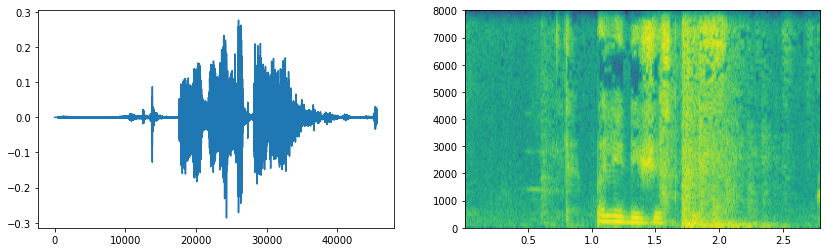

In [5]:
# load one recording
waveform, rate = lb.load('drive/MyDrive/Colab Notebooks/data/clips/1a7b4c57ea08555e6c968cbcc8875ecf70b3df42207e9556d71f1fd40b3de915d0bae21d9fe740aa56b32ad7b3dea958168bb3a84d583b3c6d46c5d2a7c5bcbe.mp3', sr = 16000)

fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].plot(waveform)
ax[1].specgram(waveform[1000:], Fs=16000, mode='psd', scale='dB')
plt.show()

#### Data Loader

In [6]:
# check out dataframe
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/ASR_train.csv')
print(df.keys())
print(df.head(5))

Index(['ID', 'up_votes', 'down_votes', 'age', 'gender', 'transcription'], dtype='object')
                                                  ID  ...                  transcription
0  002e50c29ac2890c7cb3b3d63dcbe512bc6850de206ca8...  ...                        Malicka
1  0031672b4484f963c8a07babe6f713dd559539d44140e8...  ...  Ecole Elementaire Pikine Nord
2  00362ccc6b48d3ea225e12ddf8a06a9d582cccc03b0353...  ...         Cimetière de Cambérène
3  0042cdb4d4a015cddacc26d88faffdd714b7a27213d2b3...  ...                Tournalou Boune
4  00439f02fa8f0dade934bdb317199b71662e9396f6bb81...  ...             Pharmacie Golf Sud

[5 rows x 6 columns]


In [7]:
# suppress annoying warnings while reading audio files
import warnings
warnings.filterwarnings('ignore')

In [8]:
## read into memory (small) -> storing takes around 2hrs
## IMPORTANT: it's not persisted across sessions (why not?)
import os.path
import pandas as pd

nsamples = len(df)

# check if already existent
if os.path.isfile('drive/MyDrive/Colab Notebooks/data/ASR_train_audio'+str(nsamples)+'.ft'):
    print ("File exist")
    df = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio'+str(nsamples)+'.ft')
else:
    print("File does not exist")

    # initialize with list
    audio_signals = len(df['ID'])*[[0]]
    df['audio_signal'] = audio_signals

    # functional but not elegant (nor fast probably)
    for k in range(nsamples):
      id = df.iloc[k]['ID']
      path_data = os.path.join('drive/MyDrive/Colab Notebooks/data/clips/', id+'.mp3')
      waveform, rate = lb.load(path_data, sr=16*1e3)
      df.at[k, 'audio_signal'] = waveform

      if k % 100 == 0:
        print('file '+ str(k))

    # store as faster feather format
    df[:nsamples].to_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio'+str(nsamples)+'.ft')

    #
    df = df[:nsamples]

File exist


### Model

#### XLSR Model Transformers

In [ ]:
## useful links
# https://github.com/pytorch/fairseq/tree/master/examples/wav2vec
# https://github.com/pytorch/fairseq/issues/3199
# https://bleepcoder.com/fairseq/708379224/wav2vec-2-0-inference-pipeline
# https://huggingface.co/transformers/training.html
# https://huggingface.co/blog/fine-tune-xlsr-wav2vec2 fine-tuning XLSR
# https://distill.pub/2017/ctc/ sequence modeling with CTC

#### Data

In [9]:
## dataset library (1-2GB/s data processing)
!pip install nlp
from nlp import Dataset
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size=0.2)

data_train = Dataset.from_pandas(df_train[['ID', 'transcription', 'audio_signal']])
data_valid = Dataset.from_pandas(df_valid[['ID', 'transcription', 'audio_signal']])

     |████████████████████████████████| 1.7MB 4.1MB/s 


In [10]:
## Lower casing (no punctuation included)
import re
def remove_special_characters(batch):
    batch['text'] = batch["transcription"].lower() + ' ' # lower casing + word separator at the end
    return batch

data_train = data_train.map(remove_special_characters, remove_columns=['transcription'])
data_valid = data_valid.map(remove_special_characters, remove_columns=['transcription'])

In [ ]:
## build vocabulary
# Q: exclude {, | -} ?
def extract_all_chars(batch):
  all_text = " ".join(batch['text'])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocab_train = data_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=data_train.column_names)
vocab_valid = data_valid.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=data_train.column_names)

In [ ]:
## creating vocab dictionary
import json
import os

#
vocab_list = list(set(vocab_train["vocab"][0]))

vocab_dict = {v: k for k, v in enumerate(vocab_list)}
print(vocab_dict)

# add unknown token, blank token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

print(len(vocab_dict)) # dim required for linear layer

vocab_path = os.path.join(path, "data/vocab.json")
with open(vocab_path, 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

#### Pre-Processing

In [ ]:
## tokenizer (for output text)
from transformers import Wav2Vec2CTCTokenizer

# tokenizer = Wav2Vec2CTCTokenizer(vocab_path, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token=" ")
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french") # IMPORTANT: before used Wav2VecTokenizer (not CTC)

#tokenizer.get_vocab()

In [ ]:
## feature extractor (best guess: for input to cut into windows, normalize etc.)
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

## processor (combine tokenizer and feature extractor)
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

#### Preprocess Data

In [ ]:
print(data_train[0]['ID'])
print(data_train[0]['text'])
print(data_train[0]['audio_signal'])

In [ ]:
## listen to a sample
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(data_train))
print("Target text:", data_train[rand_int]["text"])

ipd.Audio(data=np.asarray(data_train[rand_int]["audio_signal"]), autoplay=True, rate=16000)

In [ ]:
## extract input_values (normalization)
def prepare_dataset(batch):
    batch["input_values"] = processor(batch["audio_signal"], sampling_rate=16*1e3).input_values

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

# parameter num_proc does not exist in the currently used version of datasets
data_train = data_train.map(prepare_dataset, remove_columns=data_train.column_names, batch_size=8, batched=True)
data_valid = data_valid.map(prepare_dataset, remove_columns=data_valid.column_names, batch_size=8, batched=True)

#### Training

In [ ]:
## data collator (dynamic padding)
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        # input_values, attention_mask, labels
        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
## metric
!pip install jiwer
from datasets import load_metric

wer_metric = load_metric("wer")

def compute_metrics(pred):
    # argmax of softmax
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # -100 id -> pad token
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    # prediction id -> character
    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics?
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
## model
## Note: play around with hyperparameters (take training to laptop and perform grid search?)
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53-french",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, # save GPU memory
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id, # define pad token
    #vocab_size=len(processor.tokenizer) -> mis-match of last layer due to vocab size
)

# TODO: remove output layer and replace with vocabulary sized

In [ ]:
model.to('cuda');

In [ ]:
## Freeze CNN layers (no fine tuning as stated in paper)
model.freeze_feature_extractor()

In [ ]:
# TESTING: freeze all layers
'''
for name, param in model.named_parameters():
  # param.requires_grad = False
  if 'lm_head' not in name:
    param.requires_grad = False

  if param.requires_grad:
    print(name)
'''

In [ ]:
# adapt last layer to vocab size
# (lm_head): Linear(in_features=1024, out_features=37, bias=True)
# model.lm_head = torch.nn.Linear(1024, out_features=len(processor.tokenizer), bias=True)

In [ ]:
## hyperparameters
from transformers import TrainingArguments

path_model = os.path.join(path, '/model/wav2vec2-large-xlsr-french-test')

training_args = TrainingArguments(
  output_dir='./drive/MyDrive/Colab Notebooks/model/wav2vec2-large-xlsr-french-test/', # for some reason it does not save all necessary files in my own gdrive
  group_by_length=True,
  per_device_train_batch_size=16,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True,
  save_steps=150,
  eval_steps=50,
  logging_steps=70,
  learning_rate=3e-4,
  warmup_steps=20,
  save_total_limit=1,
)

In [ ]:
## Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_train,
    eval_dataset=data_valid,
    tokenizer=processor.feature_extractor,
)

In [ ]:
## prevent disconnecting
# right mouse click -> inspect -> Console tab and insert code
'''
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
'''

In [ ]:
## start training
trainer.train()

In [ ]:
#from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
modelTest = Wav2Vec2ForCTC.from_pretrained('./drive/MyDrive/Colab Notebooks/model/wav2vec2-large-xlsr-french-test/checkpoint-150/').to("cuda")
processorTest = Wav2Vec2Processor.from_pretrained('./drive/MyDrive/Colab Notebooks/model/wav2vec2-large-xlsr-french-test/checkpoint-150/') # for some reason the file is not found

#
input_dict = processor(df["audio_signal"][0], return_tensors="pt", padding=True, sampling_rate=16*1e3)
logits = model(input_dict.input_values.to("cuda")).logits
pred_ids = torch.argmax(logits, dim=-1)[0]

print("Prediction:")
print(processor.decode(pred_ids))

print("\nReference:")
print(df["transcription"][0].lower())


In [ ]:
## prediction
# load data (dataframe) -> empty entries
df_test = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_test_audio1564.ft')
df_test = df_test['audio_signal']

# pre-process (processor)
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, Wav2Vec2ForCTC

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french") #
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

# pass through model
modelTest = Wav2Vec2ForCTC.from_pretrained('./drive/MyDrive/Colab Notebooks/model/wav2vec2-large-xlsr-french-test/checkpoint-280/').to("cuda")

def prepare_dataset(batch):
    return processor(batch, return_tensors="pt", sampling_rate=16*1e3)

In [ ]:
print(df_test.keys())

# parameter num_proc does not exist in the currently used version of datasets
input_dict = df_test.apply(prepare_dataset)
print(input_dict)

In [ ]:
input_dict[0].input_values

In [ ]:
# input_features = [{"input_values": feature["input_values"]} for feature in features]
input_features = [feature.input_values[0].to("cuda") for feature in input_dict]
preds = []

for i in range(len(df_test)):
  logits = modelTest(input_dict[i].input_values.to('cuda')).logits
  pred_ids = torch.argmax(logits, dim=-1)
  preds.append(processor.decode(pred_ids[0]))

dfpred = pd.DataFrame([preds])

# save as csv
#dfpred.to_csv('./drive/MyDrive/Colab Notebooks/predictions_24Mar.csv')

In [ ]:
#df_test = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_test_audio1564.ft')
#df_test = df_test[['ID', 'audio_signal']]

dfpred = pd.DataFrame(list(zip(list(df_test['ID'].values), preds)), columns=['ID', 'transcription'])


In [ ]:
len(list(df_test['ID'].values))

In [ ]:
print(dfpred.head(5))

In [ ]:
dfpred.to_csv('./drive/MyDrive/Colab Notebooks/predictions_25Mar.csv', index=False)